In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
from main import DB_CONNECTION

In [2]:
import os

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figures")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Importing the Data from SQLite

In [3]:
con = sqlite3.connect(DB_CONNECTION)
query = "select * from matches where duration > 1200 and lobby_type = 7 and game_mode = 22"
df = pd.read_sql_query(query, con)

In [4]:
print(df.shape)

(313261, 14)


In [5]:
print(df.head())

     match_id  match_seq_num  radiant_win  start_time  duration  avg_mmr  \
0  6311906704     5275289383            0  1639027412      2094   3453.0   
1  6311906705     5275291814            1  1639027413      2481      NaN   
2  6311906706     5275299190            0  1639027412      3030      NaN   
3  6311906709     5275304560            0  1639027392      3979   3771.0   
4  6311906710     5275288412            1  1639027392      1957      NaN   

   num_mmr  lobby_type  game_mode  avg_rank_tier  num_rank_tier  cluster  \
0      2.0           7         22             52              3      153   
1      NaN           7         22             21              6      273   
2      NaN           7         22             38              2      346   
3      1.0           7         22             13              3      121   
4      NaN           7         22             13              3      191   

     radiant_team         dire_team  
0  68,25,87,104,1   83,101,97,44,17  
1  104,13,

# Prepare dataset

In [6]:
team_draft_column_names = ['radiant_team', 'dire_team']

### Build the hero id to hero name map

In [7]:
HERO_JSON = r"heroes.json"
f = open(HERO_JSON)
heroes = json.load(f)
f.close()
hero_id_map = {}
for hero_id in heroes:
    hero_id_map[hero_id] = heroes[hero_id]['localized_name'].replace(' ', '_').lower()
len(hero_id_map.values())

122

### Prepare-dataset function

In [8]:
def prepare_dataset(df):
    # drop useless columns 
    df.drop(['match_id', 'match_seq_num', 'start_time', 'duration', 'num_mmr', 'avg_mmr',
             'lobby_type', 'game_mode', 'avg_rank_tier', 'num_rank_tier', 'cluster'],
            axis=1, inplace=True)
    # construct the feature vector team_name x hero_name 
    for team in team_draft_column_names:
        df = pd.concat([df, df[team].str.get_dummies(sep=',').rename(columns=lambda s: f'{team}_{hero_id_map[s]}')],
                       axis=1)
    # drop the previous team draft columns
    df.drop(team_draft_column_names,
            axis=1, inplace=True)
    return df

In [9]:
df = prepare_dataset(df)

In [10]:
df.head()

radiant_win  radiant_team_anti-mage  radiant_team_morphling  \
0            0                       1                       0   
1            1                       0                       0   
2            0                       0                       0   
3            0                       0                       0   
4            1                       0                       0   

   radiant_team_tusk  radiant_team_skywrath_mage  radiant_team_abaddon  \
0                  0                           0                     0   
1                  0                           0                     0   
2                  0                           0                     0   
3                  0                           0                     0   
4                  0                           0                     0   

   radiant_team_elder_titan  radiant_team_legion_commander  \
0                         0                              1   
1                         0                              1   
2                         0                              0   
3                         0                              0   
4                         0                              0   

   radiant_team_techies  radiant_team_ember_spirit  ...  \
0                     0                          0  ...   
1                     0                          0  ...   
2                     0                          0  ...   
3                     0                          0  ...   
4                     0                          0  ...   

   dire_team_keeper_of_the_light  dire_team_io  dire_team_visage  \
0                              0             0                 0   
1                              0             0                 0   
2                              0             0                 0   
3                              0             0                 0   
4                              0             0                 0   

   dire_team_slark  dire_team_medusa  dire_team_troll_warlord  \
0                0                 0                        0   
1                0                 0                        0   
2                0                 0                        0   
3                0                 0                        0   
4                0                 0                        0   

   dire_team_centaur_warrunner  dire_team_magnus  dire_team_timbersaw  \
0                            0                 1                    0   
1                            0                 0                    0   
2                            0                 0                    0   
3                            0                 0                    0   
4                            0                 0                    1   

   dire_team_bristleback  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 245 columns]

In [11]:
df.shape

(313261, 245)

# Explore dataset

 ### Balance between radiance wins and loses

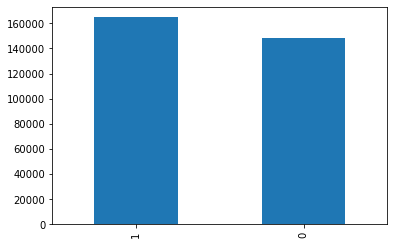

In [12]:
df['radiant_win'].value_counts().plot(kind='bar');

Saving figure radiant_w_l


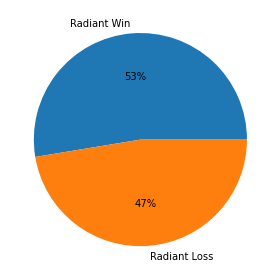

In [13]:
pie_chart_data = df['radiant_win'].value_counts()
pie_chart_labels = ['Radiant Win', 'Radiant Loss']
plt.figure(figsize=(4, 4))
plt.pie(pie_chart_data, labels=pie_chart_labels, autopct='%.0f%%')
save_fig('radiant_w_l')
plt.show()


### Stats per hero

In [14]:
hero_stats = {'hero_name': [], 'games': [], 'wins': [], 'win_rate': []}
for hero in hero_id_map.values():
    team_radiant_games = df[f'{team_draft_column_names[0]}_{hero}'].sum()
    team_dire_games = df[f'{team_draft_column_names[1]}_{hero}'].sum()
    total_games = team_radiant_games + team_dire_games

    team_radiant_wins = sum(df['radiant_win'] & df[f'{team_draft_column_names[0]}_{hero}'])
    team_dire_wins = sum(df['radiant_win'] & df[f'{team_draft_column_names[1]}_{hero}'])
    total_wins = team_radiant_wins + team_dire_wins
    win_rate = total_wins / total_games

    hero_stats['hero_name'].append(hero)
    hero_stats['games'].append(total_games)
    hero_stats['wins'].append(total_wins)
    hero_stats['win_rate'].append(win_rate)

hero_stats_df = pd.DataFrame(hero_stats).sort_values(by='games', ascending=False)
hero_stats_df.head()

hero_name  games   wins  win_rate
13             pudge  89841  47973  0.533977
24              lion  74419  39179  0.526465
82         ogre_magi  68245  35893  0.525943
42  phantom_assassin  62197  32478  0.522180
72           invoker  60179  31524  0.523837

In [15]:
hero_stats_df.describe()

games          wins    win_rate
count    122.000000    122.000000  122.000000
mean   25677.131148  13505.573770    0.525629
std    16804.736993   8858.514306    0.004437
min     1400.000000    721.000000    0.508834
25%    12576.750000   6601.500000    0.523149
50%    23274.000000  12286.500000    0.525994
75%    34959.000000  18409.750000    0.528088
max    89841.000000  47973.000000    0.538085

In [16]:
# Win rate coefficient of variation
hero_stats_df['win_rate'].std() / hero_stats_df['win_rate'].mean()

0.008441334996116661

Saving figure hero_games_barplot


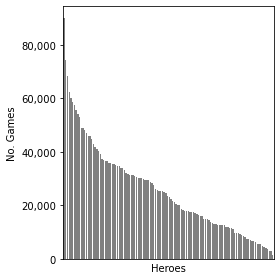

In [17]:
plt.figure(figsize=(4, 4))
# plot barh chart with index as x values
ax = sns.barplot(x='hero_name', y='games', data=hero_stats_df, color="gray", saturation=.2)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Heroes", ylabel='No. Games')
# add proper Heroes as x labels
plt.tick_params(
    axis='x',  # changes apply to the x-axis
    which='both',  # both major and minor ticks are affected
    bottom=False,  # ticks along the bottom edge are off
    top=False,  # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off
save_fig('hero_games_barplot')
plt.show()

### Representation of each hero in dataset

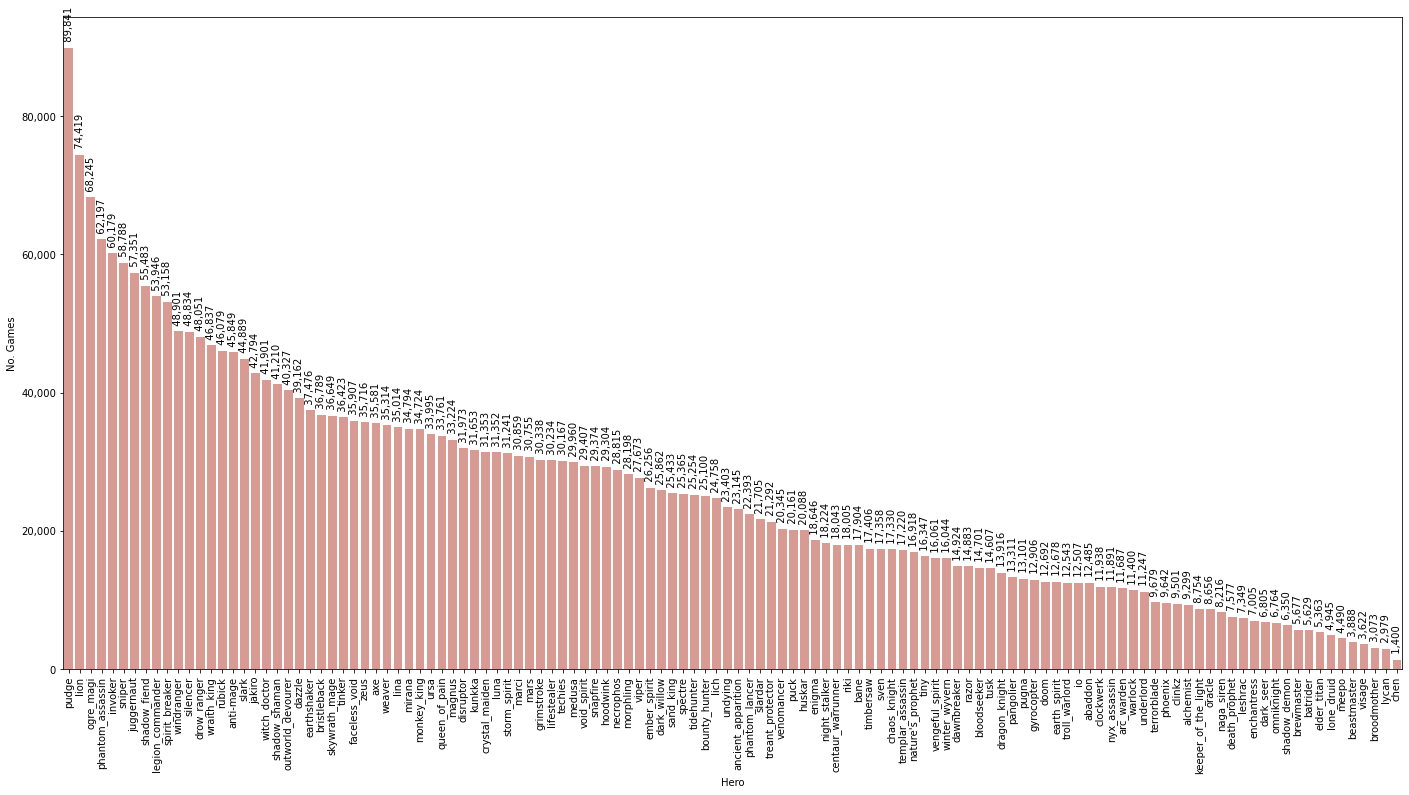

In [18]:
plt.figure(figsize=(24, 12))
# plot barh chart with index as x values
ax = sns.barplot(x='hero_name', y='games', data=hero_stats_df, color="salmon", saturation=.5)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Hero", ylabel='No. Games')
# add proper Heroes as x labels
ax.set_xticklabels(hero_stats_df.hero_name)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(hero_stats_df["games"].iteritems()):
    ax.text(i, v[1], "  {:,}".format(v[1]), va='bottom', ha='center', rotation=90)
plt.show()

Saving figure hero_winrate_barplot


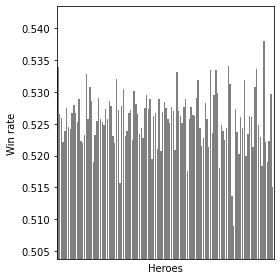

In [19]:
plt.figure(figsize=(4, 4))
# plot barh chart with index as x values
ax = sns.barplot(x='hero_name', y='win_rate', data=hero_stats_df, color="gray", saturation=.2)
ax.set(ylim=(hero_stats_df.win_rate.min() * 0.99, hero_stats_df.win_rate.max() * 1.01))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}".format(x)))
ax.set(xlabel="Heroes", ylabel='Win rate')
# add proper Heroes as x labels
plt.tick_params(
    axis='x',  # changes apply to the x-axis
    which='both',  # both major and minor ticks are affected
    bottom=False,  # ticks along the bottom edge are off
    top=False,  # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off
save_fig('hero_winrate_barplot')
plt.show()

### Win rate per hero

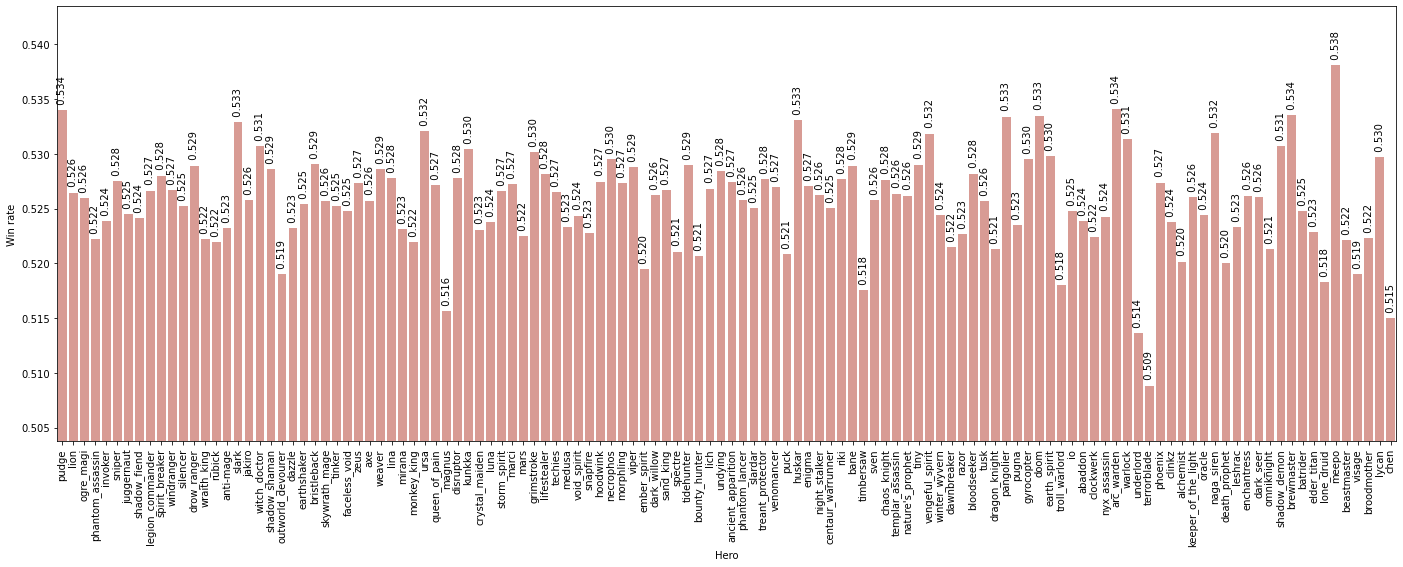

In [20]:
plt.figure(figsize=(24, 8))
ax = sns.barplot(x='hero_name', y='win_rate', data=hero_stats_df, color="salmon", saturation=.5)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}".format(x)))
ax.set(ylim=(hero_stats_df.win_rate.min() * 0.99, hero_stats_df.win_rate.max() * 1.01))
ax.set(xlabel="Hero", ylabel='Win rate')
ax.set_xticklabels(hero_stats_df.hero_name)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(hero_stats_df["win_rate"].iteritems()):
    ax.text(i, v[1], "  {:.3f}".format(v[1]), va='bottom', ha='center', rotation=90)
plt.show()

# Models

### Split in X an Y

In [21]:
df_x = df.drop(columns=['radiant_win'], axis=1)
df_y = df['radiant_win']

### Splitting data

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
random_state = 22

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=22)

### Plot confusion matrix

In [25]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix


def plot_conf_matrix(title, y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap=plt.cm.copper,
                xticklabels=['Pred Radiant Win', 'Pred Dire Win'],
                yticklabels=['Actual Radiant Win', 'Actual Dire Win'],
                fmt='d')
    plt.title("{} \n Confusion Matrix".format(title), fontsize=14)



### Plot ROC AOC

In [26]:
from sklearn.metrics import plot_roc_curve, roc_curve


def plot_roc(clf, X_train, y_train, X_test, y_test):
    """Function to plot ROC curve for the model
    Takes in 5 params; no return values
    cm: an estimator model object
    X_train: the features for the training set
    y_train: the true y values for the training set
    X_test: the features for the test set
    y_test: the true y values for the test set"""

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
    plot_roc_curve(clf, X_train, y_train, ax=axes[0])
    axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axes[0].set_title("ROC Curve for Training")

    plot_roc_curve(clf, X_test, y_test, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axes[1].set_title("ROC Curve for Testing")

    plt.show()

In [27]:
from sklearn.model_selection import GridSearchCV

### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}

# best_lr_clf = GridSearchCV(LogisticRegression(), param_grid = lr_param_grid, verbose=True, scoring='roc_auc').fit(x_train, y_train)

In [30]:
# best_lr_clf.best_estimator_ 
best_lr_clf = LogisticRegression(C=0.1, solver='liblinear').fit(x_train, y_train)

In [31]:
# best_lr_clf.best_score_

In [32]:
lr_predictions = best_lr_clf.predict(x_test)

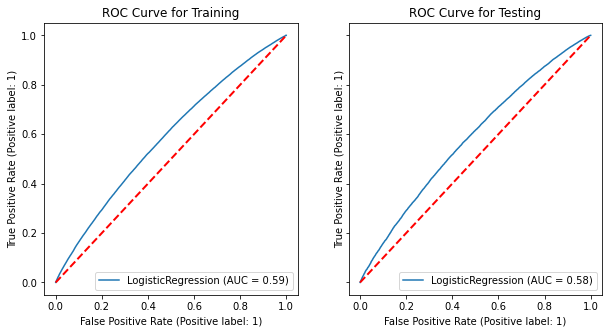

In [33]:
plot_roc(best_lr_clf, x_train, y_train, x_test, y_test)

Saving figure confusion_matrix_lr


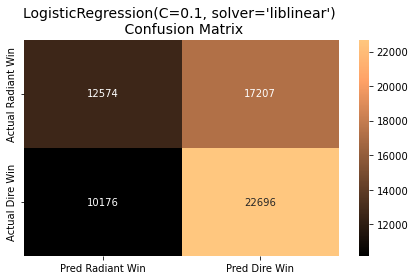

In [34]:
plot_conf_matrix(str(best_lr_clf), lr_predictions, y_test)
save_fig('confusion_matrix_lr')

### RandomForestClassifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
rfc_param_grid = {
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 25, 50]
}

# best_rfc_clf = GridSearchCV(RandomForestClassifier(), param_grid = rfc_param_grid, verbose=True, n_jobs=-1, scoring='roc_auc').fit(x_train, y_train)

In [37]:
# best_rfc_clf.best_estimator_ 
best_rfc_clf = RandomForestClassifier(n_estimators=500, max_features='sqrt', criterion='entropy', max_depth=10,
                                      min_samples_split=0.1, n_jobs=-1, random_state=22).fit(x_train, y_train)

In [38]:
# best_rfc_clf.best_score_

In [39]:
rfc_predictions = best_rfc_clf.predict(x_test)

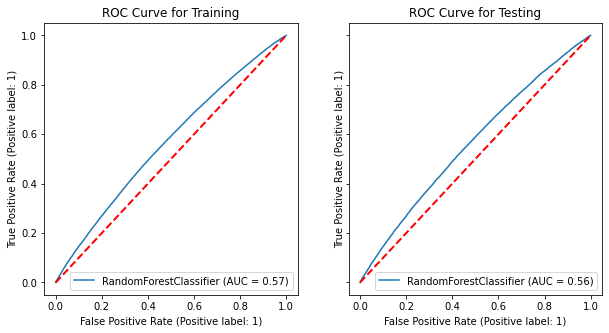

In [40]:
plot_roc(best_rfc_clf, x_train, y_train, x_test, y_test)

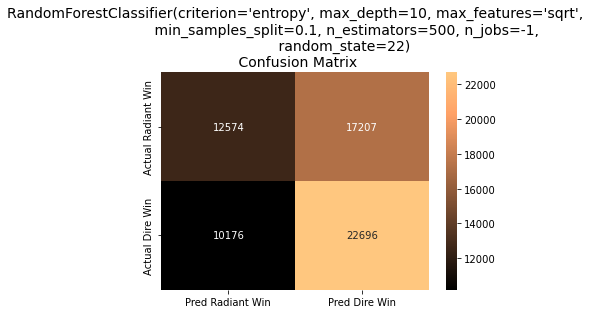

In [41]:
plot_conf_matrix(str(best_rfc_clf), lr_predictions, y_test)

### GradientBoostingClassifier

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

In [43]:
gbc_param_grid = {
    'max_depth': [3, 4, 5, 6],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['mae', 'friedman_mse'],
    'n_estimators': [100, 175]
}

# best_gbc_clf = GridSearchCV(GradientBoostingClassifier(), param_grid = gbc_param_grid, verbose=True, scoring='roc_auc').fit(x_train, y_train)

In [44]:
# best_gbc_clf.best_estimator_ 

In [45]:
# best_gbc_clf.best_score_

In [46]:
best_gbc_clf = GradientBoostingClassifier(max_depth=4, max_features='sqrt', criterion='friedman_mse').fit(x_train,
                                                                                                          y_train)

In [47]:
gbc_predictions = best_gbc_clf.predict(x_test)

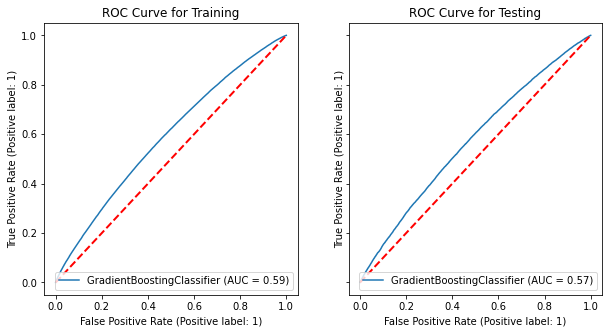

In [48]:
plot_roc(best_gbc_clf, x_train, y_train, x_test, y_test)

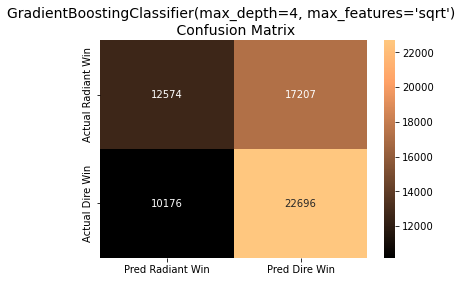

In [49]:
plot_conf_matrix(str(best_gbc_clf), lr_predictions, y_test)

### Comparing models

Saving figure roc_curve_comparasion


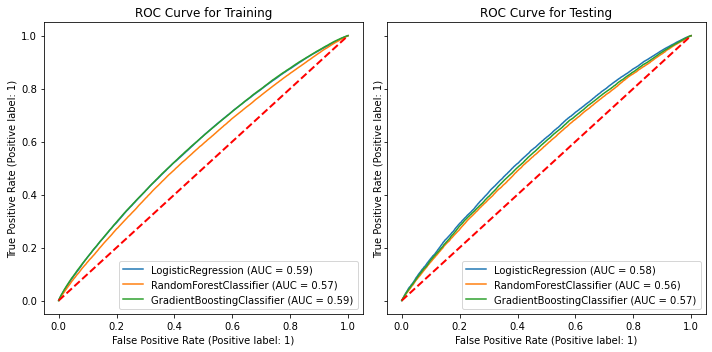

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
plot_roc_curve(best_lr_clf, x_train, y_train, ax=axes[0])
plot_roc_curve(best_rfc_clf, x_train, y_train, ax=axes[0])
plot_roc_curve(best_gbc_clf, x_train, y_train, ax=axes[0])
axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[0].set_title("ROC Curve for Training")

plot_roc_curve(best_lr_clf, x_test, y_test, ax=axes[1])
plot_roc_curve(best_rfc_clf, x_test, y_test, ax=axes[1])
plot_roc_curve(best_gbc_clf, x_test, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[1].set_title("ROC Curve for Testing")
save_fig('roc_curve_comparasion')
plt.show()